# Plots for the speed test of ABCDe algorithm

## Data preprocessing:

In [1]:
using Base.Iterators
using Random
using DataFrames
using PyPlot
using StatsBase
using LaTeXStrings, Latexify

In [2]:
seed = 33;
dir = "speed_test/benchmark_res";

In [3]:
Random.seed!(seed);

In [4]:
#Parameters:
algs = [:LFR, :ABCD, :ABCDe]
N = 10 .^(range(4,8,step = 1))
ξs = range(0.0, 1.0, step = 0.05)
βs = [1.1, 1.5, 1.9]
γs = [2.1, 2.5, 2.9]
min_degs = [5,10];
is_local = [true, false]
threads = [1, 2, 4, 8, 16, 32];

In [5]:
data = DataFrame(vcat(reshape(collect(product([:ABCDe,], N, ξs, NaN, βs, γs, min_degs, NaN, NaN, is_local, threads, NaN)),:), 
    reshape(collect(product([:ABCD,], N, ξs, NaN, βs, γs, min_degs, NaN, NaN, is_local, 1, NaN)),:), 
    reshape(collect(product([:LFR,], N, ξs, NaN, βs, γs, min_degs, NaN, NaN, NaN, 1, NaN)),:)));
rename!(data, [:algo, :n, :ξ, :μ, :β, :γ, :min_deg, :E_deg, :n_edges, :is_local, :threads, :time]);

In [6]:
for file in readdir(dir)
    name = Symbol(split(file,'_')[1])
    n, ξ, μ, β, γ, min_deg, E_deg, n_edges, is_local, threads, time = readlines(dir *"/"* file)
    if name == :LFR
        idx = (data[!,:algo] .== name) .& (data[!,:n] .== parse(Int,n)) .& 
            (data[!,:ξ] .== parse(Float64, ξ)) .& (data[!,:β] .== parse(Float64, β)) .& 
            (data[!,:γ] .== parse(Float64, γ)) .& (data[!,:min_deg] .== parse(Int, min_deg))
    else
        idx = (data[!,:algo] .== name) .& (data[!,:n] .== Int(parse(Float64,n))) .& 
            (data[!,:ξ] .== parse(Float64, ξ)) .& (data[!,:β] .== parse(Float64, β)) .& 
            (data[!,:γ] .== parse(Float64, γ)) .& (data[!,:min_deg] .== Int(parse(Float64, min_deg)))  .& 
            (data[!,:is_local] .== parse(Float64,is_local)) .& (data[!, :threads] .== Int(parse(Float64, threads)))
    end
    data[idx, :E_deg] .= parse(Float64, E_deg)
    data[idx, :n_edges] .= Int(parse(Float64, n_edges))
    data[idx, :μ] .= parse(Float64, μ)
    data[idx, :time] .= parse(Float64, time)
end

In [7]:
size(data)

(28350, 12)

In [8]:
fdata = data[(data[!,:n] .≤ 10^8) .& (isnan.(data[!,:time]) .== false),:];
sort!(fdata);
size(fdata)

(23465, 12)

# Time/n plot

Plotting the relation between the size of graph and the execution time for fixed $\xi$ and $\beta$ and $\gamma$.

In [9]:
#parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5
threads = [1,2,4,8,16,32];

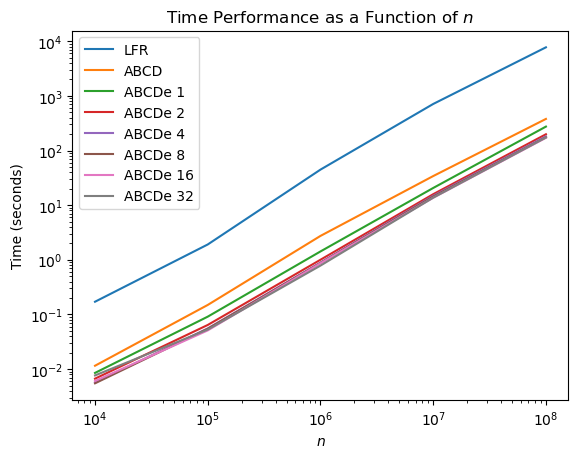

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\barto\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


PyObject Text(0.5, 1.0, 'Time Performance as a Function of $n$')

In [10]:
group = groupby(groupby(fdata,[:algo,:ξ, :β, :γ, :min_deg])[(:LFR, ξ,β, γ, min_deg)], :n);
y = [mean(d[!,:time]) for d in group]
plot(unique(fdata[!,:n]), y, label = "LFR")

group = groupby(groupby(fdata,[:algo,:ξ,:β, :γ, :min_deg])[(:ABCD, ξ, β, γ, min_deg)], :n);
y = [mean(d[!,:time]) for d in group]
plot(unique(fdata[!,:n]), y, label = "ABCD")

for thread in threads
    group = groupby(groupby(fdata,[:algo,:ξ, :β, :γ, :min_deg, :threads])[(:ABCDe, ξ, β, γ, min_deg, thread)], :n);
    y = [mean(d[!,:time]) for d in group]
    plot(unique(fdata[!,:n]), y, label = "ABCDe $thread")
end

legend(loc="upper left")
xscale("log")
xlabel(L"n")
yscale("log")
ylabel("Time (seconds)")
title(L"Time Performance as a Function of $n$")

#saving to a file:
#savefig("fig_speed_bench.eps")

# Speedup Table

In [11]:
#parameters:

ξs = [0.2, 0.5, 0.8]
β = 1.5
γ = 2.5
min_deg = 5
threads = [1,2,4,8,16,32];

In [12]:
algnames = vcat(["LFR", "ABCD"], ["ABCDe " * string(thr) for thr in threads]);
table = []
for ξ in ξs
    M = Array{Any}(undef, (length(N), length(algnames)+2))
    M[:,1] .= ξ
    M[:,2] =  Int.(N)
    group = groupby(groupby(fdata,[:algo,:ξ, :β, :γ, :min_deg])[(:LFR, ξ,β, γ, min_deg)], :n);
    LFR_ref = [mean(d[!,:time]) for d in group]
    M[:,3] = Int.(LFR_ref./LFR_ref)
    group = groupby(groupby(fdata,[:algo,:ξ, :β, :γ, :min_deg])[(:ABCD, ξ,β, γ, min_deg)], :n);
    M[:,4] = LFR_ref ./ [mean(d[!,:time]) for d in group]
    for (i,thread) in enumerate(threads)
        group = groupby(groupby(fdata,[:algo,:ξ, :β, :γ, :min_deg, :threads])[(:ABCDe, ξ, β, γ, min_deg, thread)], :n)
        M[:,4+i] = LFR_ref ./ [mean(d[!,:time]) for d in group]
    end
    M[:,4:end] = round.(M[:,4:end], digits = 2)
    push!(table,M)
end
table = vcat(table...)

#save table in latex format:
#open("speedup_table.tex", "w") do file
#    write(file, latextabular(table, latex=false, head = [:ξ, :n, Symbol.(algnames)...]))
#end

mdtable(table, latex=false, head = [:ξ, :n, Symbol.(algnames)...])

|   ξ |         n | LFR |  ABCD | ABCDe 1 | ABCDe 2 | ABCDe 4 | ABCDe 8 | ABCDe 16 | ABCDe 32 |
| ---:| ---------:| ---:| -----:| -------:| -------:| -------:| -------:| --------:| --------:|
| 0.2 |     10000 |   1 | 26.36 |   32.64 |   45.28 |   57.99 |   63.99 |    55.55 |    37.94 |
| 0.2 |    100000 |   1 |  8.55 |   13.01 |   18.24 |   25.33 |   27.31 |    28.88 |    27.93 |
| 0.2 |   1000000 |   1 |  7.94 |   16.17 |   25.22 |   36.74 |   39.05 |    39.29 |    41.27 |
| 0.2 |  10000000 |   1 | 14.82 |   24.03 |   37.08 |    48.7 |   50.84 |    56.02 |    57.63 |
| 0.2 | 100000000 |   1 |  12.0 |   15.54 |   24.07 |   32.55 |   37.11 |    37.37 |    36.41 |
| 0.5 |     10000 |   1 | 14.83 |   20.06 |   25.57 |   30.04 |   31.12 |     28.2 |    22.32 |
| 0.5 |    100000 |   1 | 12.78 |   20.93 |   29.71 |   34.35 |   34.85 |    37.37 |     36.1 |
| 0.5 |   1000000 |   1 | 16.33 |   31.43 |   44.59 |   50.13 |   50.97 |    51.74 |    57.06 |
| 0.5 |  10000000 |   1 | 20.85 |   34.45 |   44.76 |   47.87 |    49.4 |    52.04 |    51.79 |
| 0.5 | 100000000 |   1 | 20.43 |   28.23 |   38.97 |   42.53 |   44.26 |    45.29 |    44.64 |
| 0.8 |     10000 |   1 | 23.05 |   29.26 |   34.37 |   36.65 |   36.11 |    34.28 |    29.06 |
| 0.8 |    100000 |   1 | 20.45 |   36.64 |   43.24 |   47.58 |   47.25 |    46.59 |    48.46 |
| 0.8 |   1000000 |   1 | 27.27 |   45.87 |   58.36 |   59.58 |   61.25 |    63.86 |    64.87 |
| 0.8 |  10000000 |   1 | 24.71 |   40.11 |    44.6 |   47.88 |   48.83 |    48.54 |     48.7 |
| 0.8 | 100000000 |   1 |  30.9 |   37.72 |   44.05 |   44.66 |   48.54 |    48.85 |     47.5 |


# Time/ξ plot

Plotting the relation between $\xi$ and the execution time for fixed $n$, $\beta$ and $\gamma$.

In [13]:
#parameters

n = 10^7
β = 1.5
γ = 2.5
min_deg = 5
threads = [1,2,4,8,16,32];

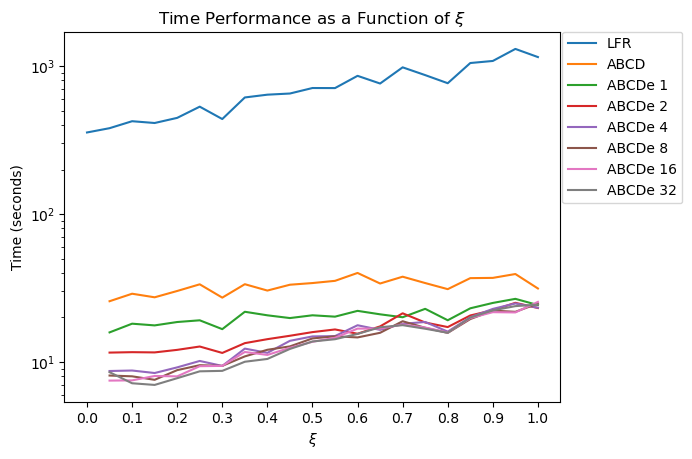

PyObject Text(0.5, 1.0, 'Time Performance as a Function of $ξ$')

In [14]:
group = groupby(groupby(fdata,[:algo, :n, :β, :γ, :min_deg])[(:LFR, n, β, γ, min_deg)], :ξ);
x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time])) for d in group]...))
plot(x, y, label = "LFR")

group = groupby(groupby(fdata,[:algo,:n, :β, :γ, :min_deg])[(:ABCD, n, β, γ, min_deg)], :ξ);
x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time])) for d in group]...))
plot(x,y, label = "ABCD")

for thread in threads
    group = groupby(groupby(fdata,[:algo,:n, :β, :γ, :min_deg, :threads])[(:ABCDe, n, β, γ, min_deg, thread)], :ξ);
    x,y = collect(zip([(unique(d[!,:ξ])[1], (mean(d[!,:time]))) for d in group]...))
    plot(x, y, label = "ABCDe $thread")
end

#legend(loc="upper left")
legend(loc="upper right", bbox_to_anchor=(1.26, 1.02))
xticks(range(0.0, 1.0, step = 0.1))
xlabel(L"ξ")
yscale("log")
ylabel("Time (seconds)")
title(L"Time Performance as a Function of $ξ$")

#saving to a file:
#savefig("speed_xi_plot.eps")

# β and γ plots

Plotting the relationships between the execution time and $n$ for different values of $\gamma$ and $\beta$.

In [15]:
#parameters:

ξ = 0.2
min_deg = 5
thread = 32

32

Relationship between $n$ and avg exec. time for different values of $\gamma$ and $\beta$:

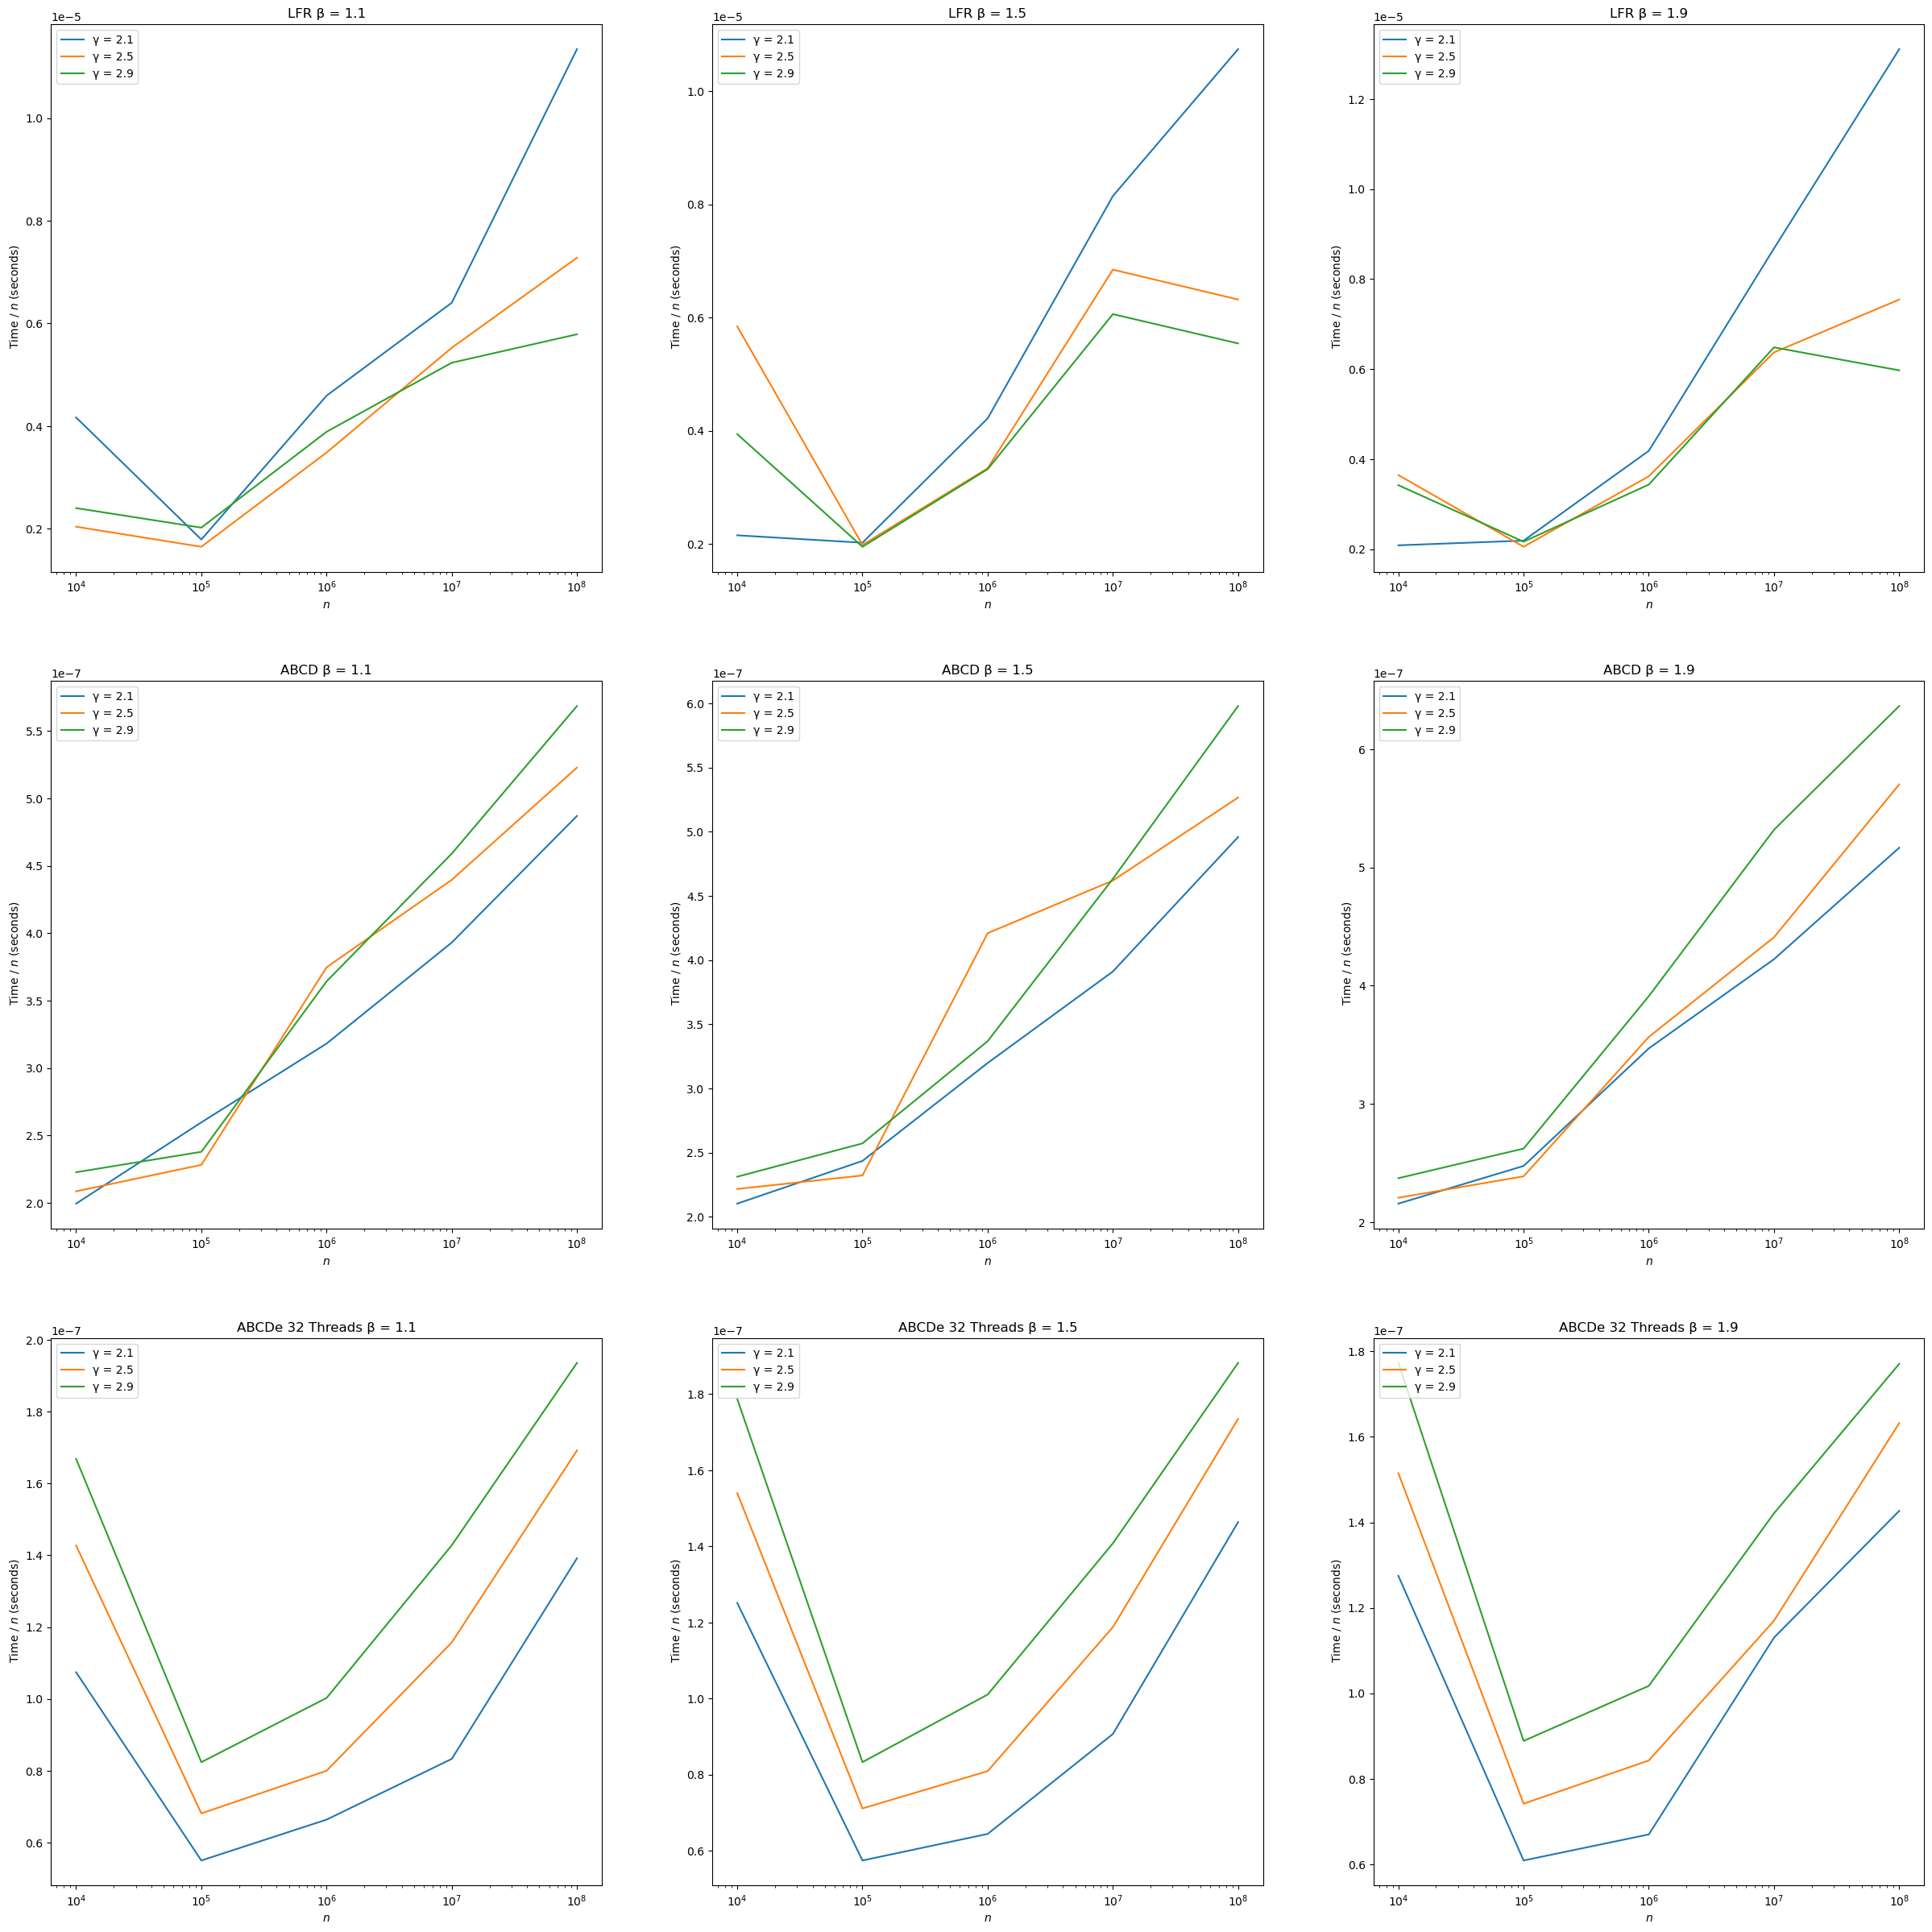

In [16]:
fig = figure(L"Time Performance as a Function of $n$ for Different Values of $γ$ and $β$",figsize = (30,30)) 
k = 1
for algo in [:LFR, :ABCD, :ABCDe]
    algo != :ABCDe ? (thr = 1) : (thr = thread)
    for (i,β) in enumerate(βs)
        subplot(parse(Int, "33" * "$k"))
        for (j,γ) in enumerate(γs)
            group = groupby(groupby(fdata, 
                    [:algo, :ξ, :γ, :β, :min_deg, :threads])[(algo, ξ, γ, β, min_deg, thr)], :n);
            y = [mean(d[!,:time] ./ d[!,:n_edges]) for d in group]
            plot(unique(fdata[!,:n]), y, label = "γ = $γ")
            legend(loc="upper left")
            xscale("log")
            xlabel(L"n")
            ylabel(L" Time / $n$ (seconds)")
        end
        algo != :ABCDe ? PyPlot.title("$algo β = $β") : PyPlot.title("$algo $thr Threads β = $β")
        k += 1
    end
end

#saving to a file:
#savefig("fig3.eps")

Relationship between $n$ and avg exec. time for different values of $\beta$ and $\gamma$:

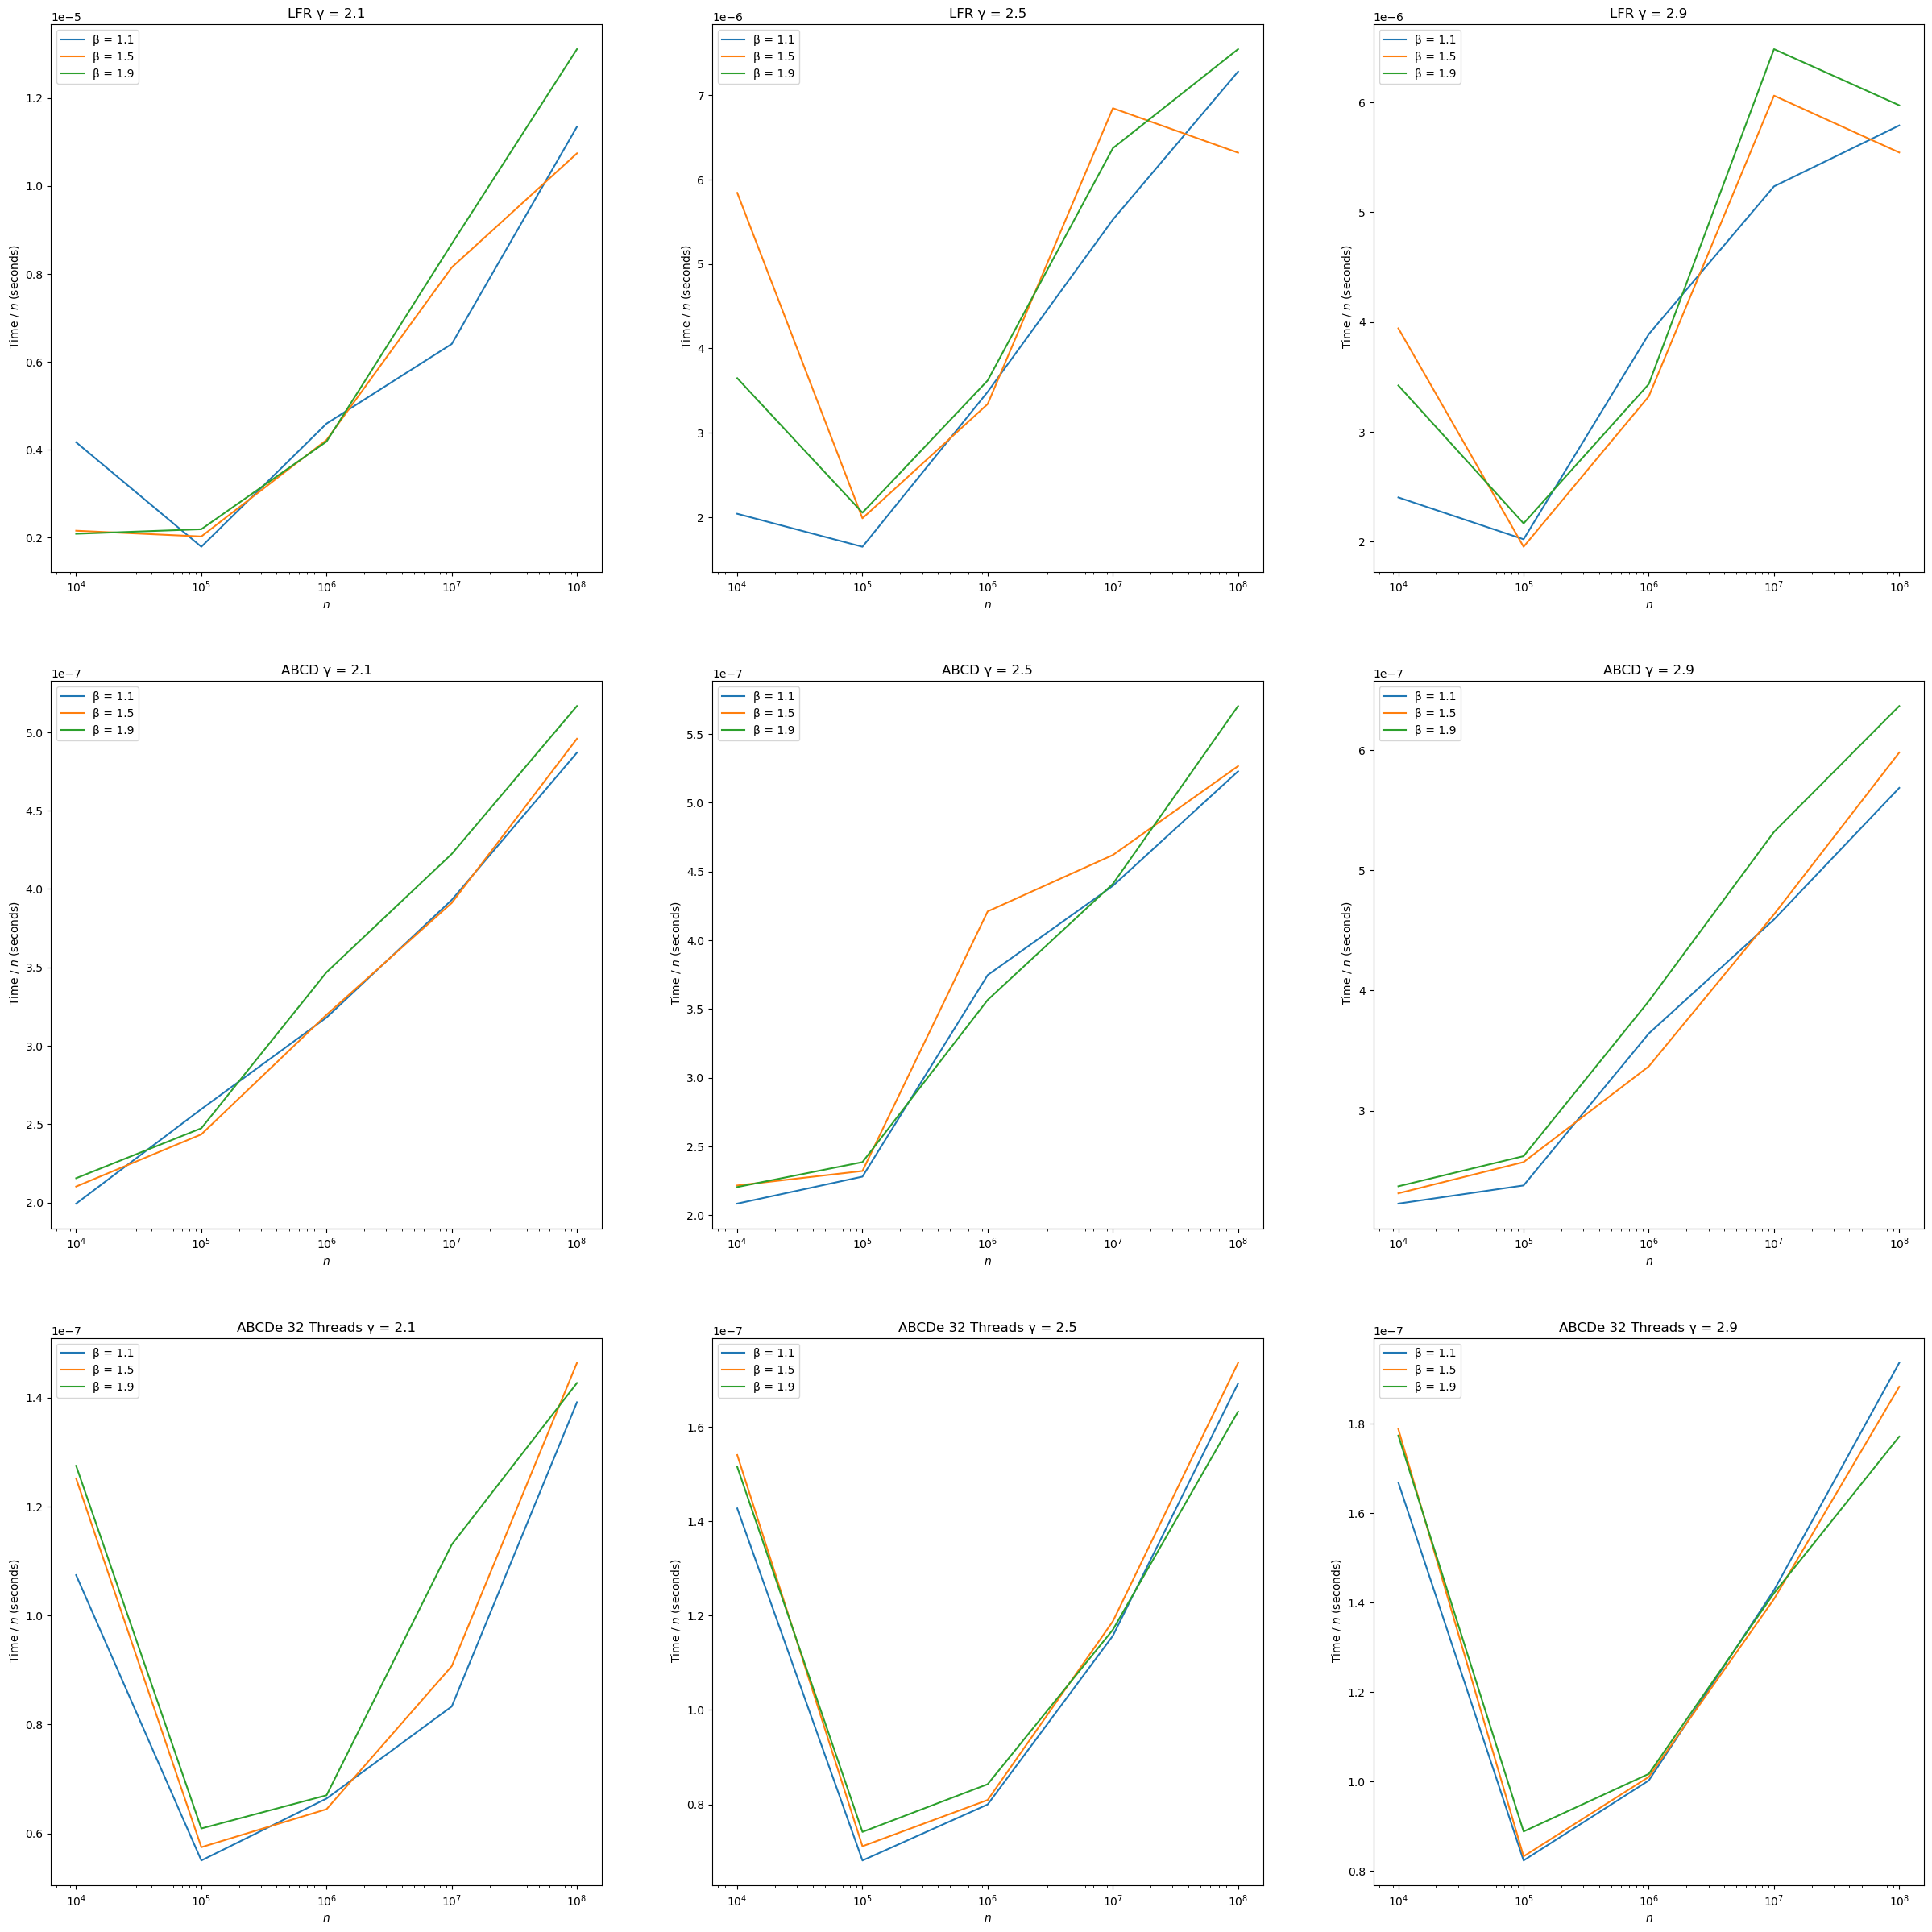

In [17]:
fig = figure(L"Time Performance as a Function of $n$ for Different Values of $β$ and $γ$",figsize = (30,30)) 
k = 1
for algo in [:LFR, :ABCD, :ABCDe]
    algo != :ABCDe ? (thr = 1) : (thr = thread)
    for (i,γ) in enumerate(γs)
        subplot(parse(Int, "33" * "$k"))
        for (j,β) in enumerate(βs)
            group = groupby(groupby(fdata, 
                    [:algo, :ξ, :γ, :β, :min_deg, :threads])[(algo, ξ, γ, β, min_deg, thr)], :n);
            y = [mean(d[!,:time] ./ d[!,:n_edges]) for d in group]
            plot(unique(fdata[!,:n]), y, label = "β = $β")
            legend(loc="upper left")
            xscale("log")
            xlabel(L"n")
            ylabel(L" Time / $n$ (seconds)")
        end
        algo != :ABCDe ? PyPlot.title("$algo γ = $γ") : PyPlot.title("$algo $thr Threads γ = $γ") 
        k += 1
    end
end

#saving to a file:
#savefig("fig4.eps")

# Min_deg impact plots

Plots showing the relationship between the execution time and $n$ or $\xi$ respectively for different values of minimal degree.

### Relationship between $n$ and average execution time for different values of min. degree:

In [18]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
thread = 8;

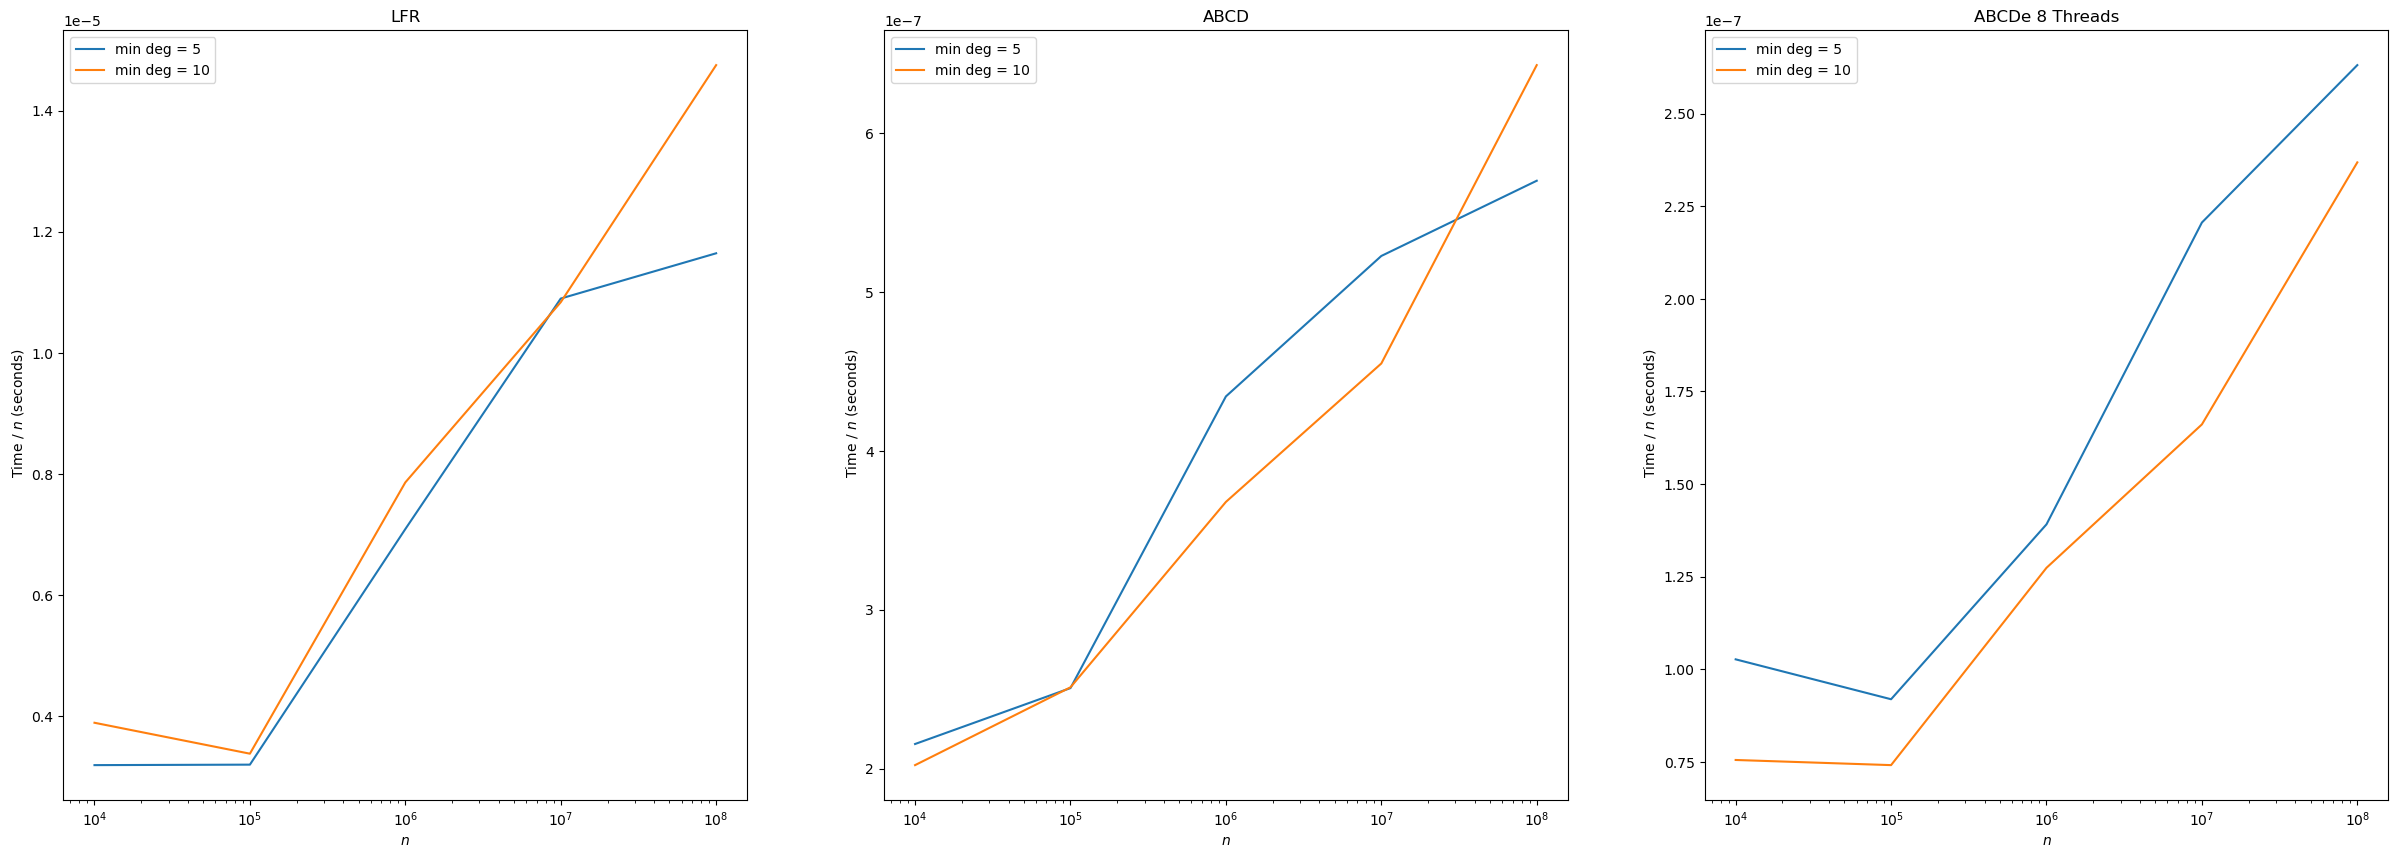

In [19]:
fig = figure(L"Time Performance as a Function of $n$ for Different Values of Min. Degree",figsize = (30,10)) 
k = 1
for algo in [:LFR, :ABCD, :ABCDe]
    algo != :ABCDe ? (thr = 1) : (thr = thread)
    subplot(parse(Int, "13" * "$k"))
    for min_deg in min_degs
        group = groupby(groupby(fdata,
                [:algo, :ξ, :β, :γ, :min_deg, :threads])[(algo, ξ, β, γ, min_deg, thr)], :n);
        y = [mean(d[!,:time] ./ d[!,:n_edges]) for d in group]
        plot(unique(fdata[!,:n]), y, label = "min deg = $min_deg")
    end
    legend(loc="upper left")
    xscale("log")
    xlabel(L"n")
    ylabel(L" Time / $n$ (seconds)")
    algo != :ABCDe ? PyPlot.title("$algo") : PyPlot.title("$algo $thr Threads") 
    k += 1
end

#saving to a file:
#savefig("fig5.eps")

### Relationship between $\xi$ and  average execution time for different values of min. degree .

In [20]:
#Parameters:

n = 10^8
β = 1.5
γ = 2.5
thread = 8;

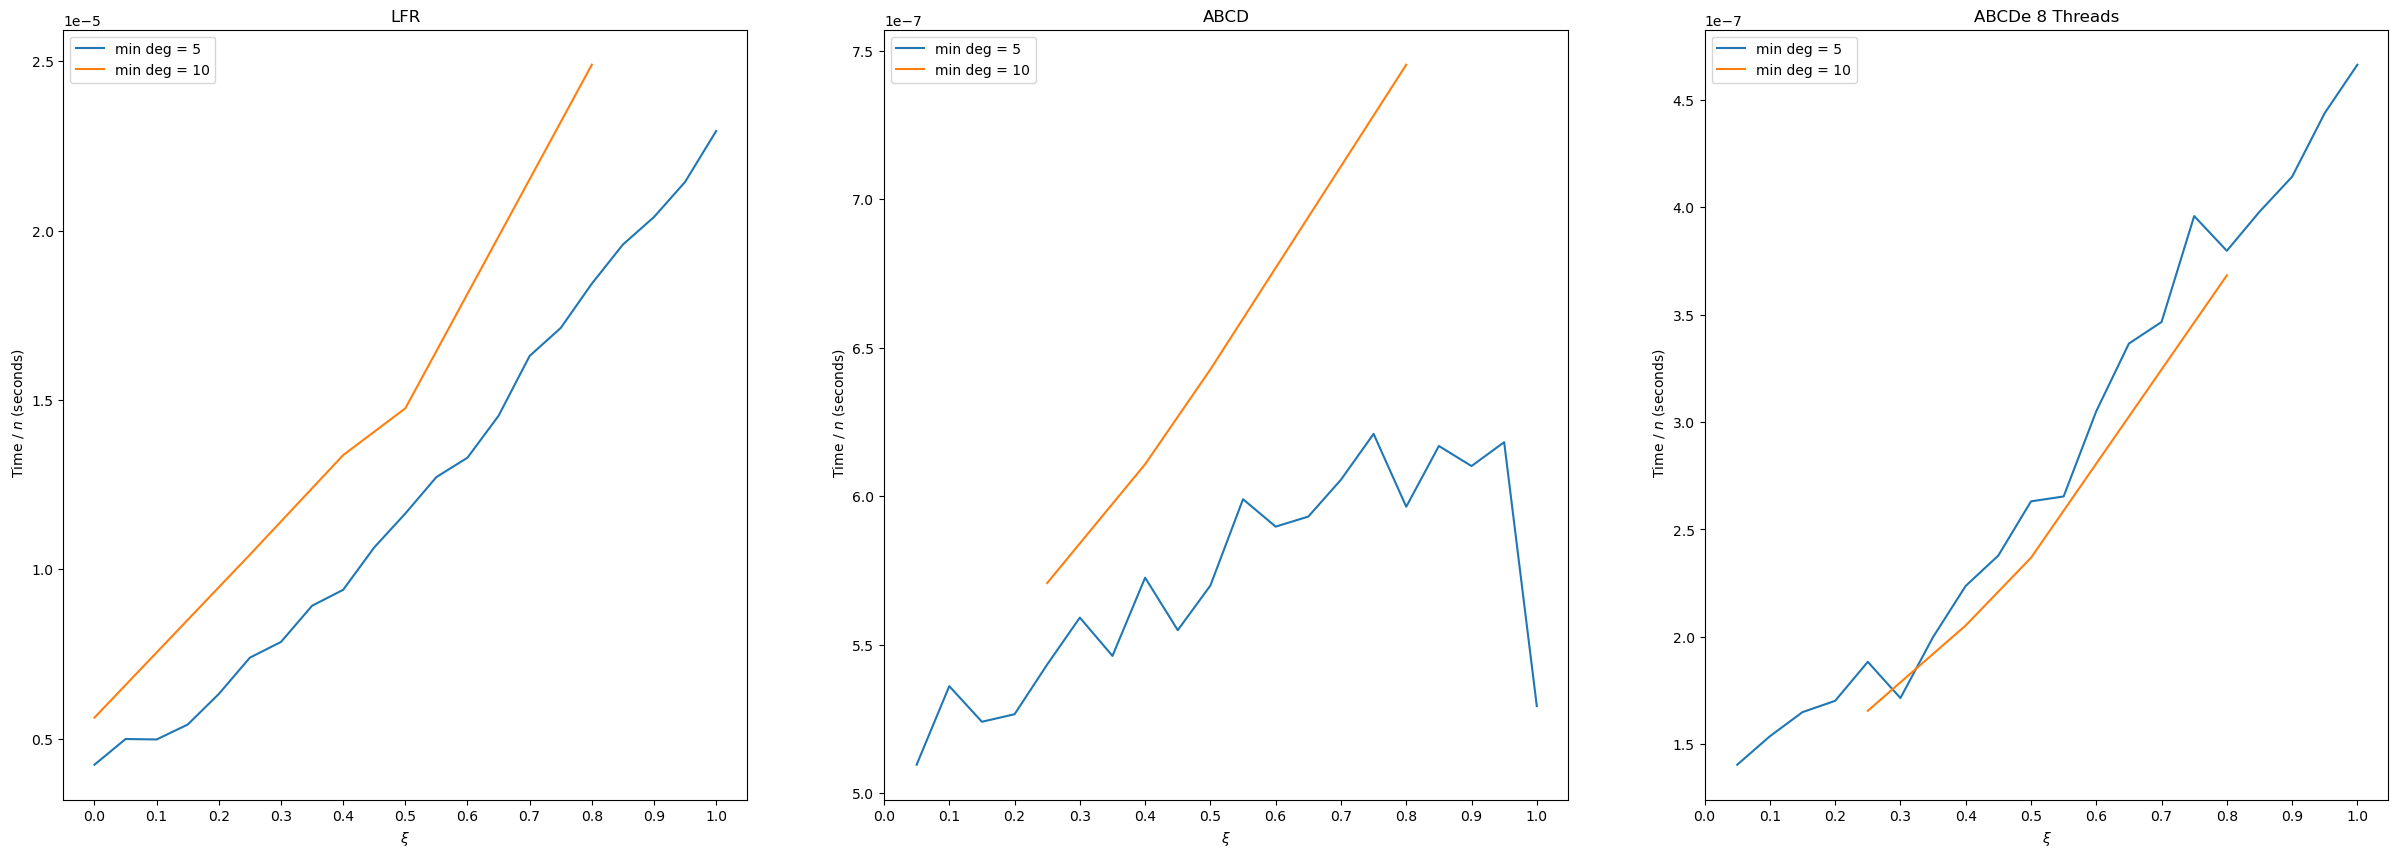

In [21]:
fig = figure(L"Time Performance as a Function of $ξ$ for Different Values of Min. Degree",figsize = (30,10)) 
k = 1
for algo in [:LFR, :ABCD, :ABCDe]
    algo != :ABCDe ? (thr = 1) : (thr = thread)
    subplot(parse(Int, "13" * "$k"))
    for min_deg in min_degs
        group = groupby(groupby(fdata,
                [:algo, :n, :β, :γ, :min_deg, :threads])[(algo, n, β, γ, min_deg, thr)], :ξ);
        x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time]./d[!,:n_edges])) for d in group]...))
        plot( x,y, label = "min deg = $min_deg")
    end
    legend(loc="upper left")
    xticks(range(0.0, 1.0, step = 0.1))
    xlabel(L"ξ")
    ylabel(L" Time / $n$ (seconds)")
    algo != :ABCDe ? PyPlot.title("$algo") : PyPlot.title("$algo $thr Threads") 
    k += 1
end

#saving to a file:
#savefig("fig6.eps")

## ABCD vs ABCDe

Detailed comparision of <b>ABCD</b> and <b>ABCDe</b> algorithms (without <b>LFR</b>).

###  Execution time as a function of $n$:

In [22]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 10

10

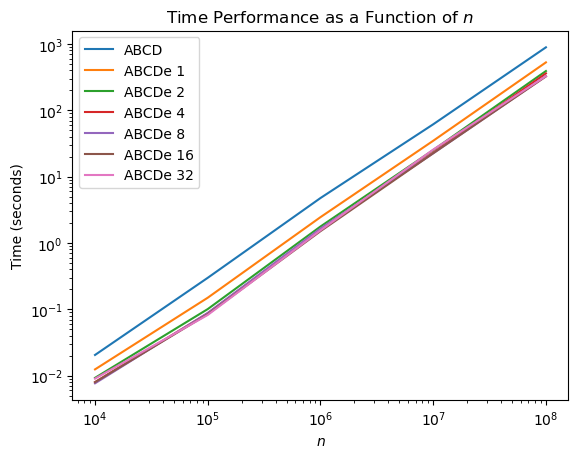

PyObject Text(0.5, 1.0, 'Time Performance as a Function of $n$')

In [23]:
group = groupby(groupby(fdata,[:algo,:ξ,:β, :γ, :min_deg])[(:ABCD, ξ, β, γ, min_deg)], :n);
y = [mean(d[!,:time]) for d in group]
plot(unique(fdata[!,:n]), y, label = "ABCD")

for thread in threads
    group = groupby(groupby(fdata,[:algo,:ξ, :β, :γ, :min_deg, :threads])[(:ABCDe, ξ, β, γ, min_deg, thread)], :n);
    y = [mean(d[!,:time]) for d in group]
    plot(unique(fdata[!,:n]), y, label = "ABCDe $thread")
end

legend(loc="upper left")
xscale("log")
xlabel(L"n")
yscale("log")
ylabel("Time (seconds)")
title(L"Time Performance as a Function of $n$")

#saving to a file:
#savefig("fig_speed_bench_without_LFR.eps")

# Speedup Table

In [24]:
#parameters:

ξs = [0.2, 0.5, 0.8]
β = 1.5
γ = 2.5
min_deg = 5
threads = [1,2,4,8,16,32];

In [25]:
algnames = vcat(["ABCD"], ["ABCDe " * string(thr) for thr in threads]);
table = []
for ξ in ξs
    M = Array{Any}(undef, (length(N), length(algnames)+2))
    M[:,1] .= ξ
    M[:,2] =  Int.(N)
    group = groupby(groupby(fdata,[:algo,:ξ, :β, :γ, :min_deg])[(:ABCD, ξ,β, γ, min_deg)], :n);
    ABCD_ref = [mean(d[!,:time]) for d in group]
    M[:,3] = Int.(ABCD_ref./ABCD_ref)
    for (i,thread) in enumerate(threads)
        group = groupby(groupby(fdata,[:algo,:ξ, :β, :γ, :min_deg, :threads])[(:ABCDe, ξ, β, γ, min_deg, thread)], :n)
        M[:,3+i] = ABCD_ref ./ [mean(d[!,:time]) for d in group]
    end
    M[:,4:end] = round.(M[:,4:end], digits = 2)
    push!(table,M)
end
table = vcat(table...)

#save table in latex format:
#open("speedup_table_without_LFR.tex", "w") do file
#    write(file, latextabular(table, latex=false, head = [:ξ, :n, Symbol.(algnames)...]))
#end

mdtable(table, latex=false, head = [:ξ, :n, Symbol.(algnames)...])

|   ξ |         n | ABCD | ABCDe 1 | ABCDe 2 | ABCDe 4 | ABCDe 8 | ABCDe 16 | ABCDe 32 |
| ---:| ---------:| ----:| -------:| -------:| -------:| -------:| --------:| --------:|
| 0.2 |     10000 |    1 |    1.24 |    1.72 |     2.2 |    2.43 |     2.11 |     1.44 |
| 0.2 |    100000 |    1 |    1.52 |    2.13 |    2.96 |    3.19 |     3.38 |     3.26 |
| 0.2 |   1000000 |    1 |    2.04 |    3.18 |    4.63 |    4.92 |     4.95 |      5.2 |
| 0.2 |  10000000 |    1 |    1.62 |     2.5 |    3.29 |    3.43 |     3.78 |     3.89 |
| 0.2 | 100000000 |    1 |    1.29 |    2.01 |    2.71 |    3.09 |     3.11 |     3.03 |
| 0.5 |     10000 |    1 |    1.35 |    1.72 |    2.03 |     2.1 |      1.9 |      1.5 |
| 0.5 |    100000 |    1 |    1.64 |    2.32 |    2.69 |    2.73 |     2.92 |     2.82 |
| 0.5 |   1000000 |    1 |    1.92 |    2.73 |    3.07 |    3.12 |     3.17 |     3.49 |
| 0.5 |  10000000 |    1 |    1.65 |    2.15 |     2.3 |    2.37 |      2.5 |     2.48 |
| 0.5 | 100000000 |    1 |    1.38 |    1.91 |    2.08 |    2.17 |     2.22 |     2.19 |
| 0.8 |     10000 |    1 |    1.27 |    1.49 |    1.59 |    1.57 |     1.49 |     1.26 |
| 0.8 |    100000 |    1 |    1.79 |    2.11 |    2.33 |    2.31 |     2.28 |     2.37 |
| 0.8 |   1000000 |    1 |    1.68 |    2.14 |    2.18 |    2.25 |     2.34 |     2.38 |
| 0.8 |  10000000 |    1 |    1.62 |     1.8 |    1.94 |    1.98 |     1.96 |     1.97 |
| 0.8 | 100000000 |    1 |    1.22 |    1.43 |    1.45 |    1.57 |     1.58 |     1.54 |


### Execution time per edge as a function of $n$:

In [26]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 10

10

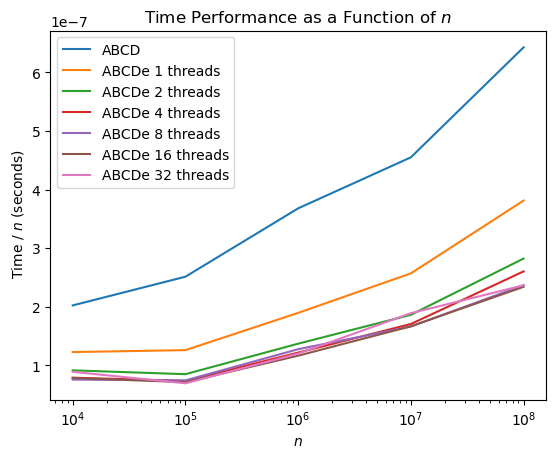

PyObject Text(0.5, 1.0, 'Time Performance as a Function of $n$')

In [27]:
group = groupby(groupby(fdata, [:algo,:ξ, :β, :γ, :min_deg])[(:ABCD, ξ, β, γ, min_deg)], :n);
y = [mean(d[!,:time] ./ d[!,:n_edges]) for d in group]
plot(unique(fdata[!,:n]), y, label = "ABCD")

for thread in threads
    group = groupby(groupby(fdata, [:algo, :ξ, :β, :γ, :min_deg, :threads])[(:ABCDe, ξ, β, γ, min_deg, thread)], :n);
    y = [mean(d[!,:time] ./ d[!,:n_edges]) for d in group]
    plot(unique(fdata[!,:n]), y, label = "ABCDe $thread threads")
end

legend(loc="upper left")
xticks(log.(10,unique(fdata[!,:n])))
xscale("log")
xlabel(L"n")
ylabel(L" Time / $n$ (seconds)")
title(L"Time Performance as a Function of $n$")

#saving to a file:
#savefig("speed_per_edge_without_LFR.eps")

### Execution time as a function of  $\xi$:

In [28]:
#Parameters:

n = 10^7
β = 1.5
γ = 2.5
min_deg = 10

10

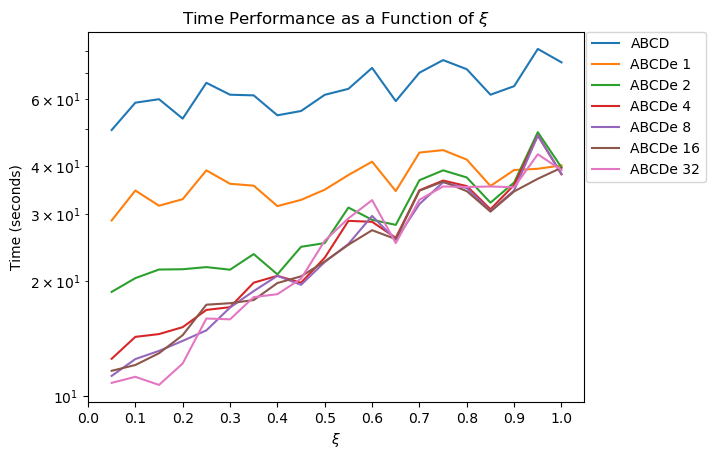

PyObject Text(0.5, 1.0, 'Time Performance as a Function of $ξ$')

In [29]:
group = groupby(groupby(fdata,[:algo,:n, :β, :γ, :min_deg])[(:ABCD, n, β, γ, min_deg)], :ξ);
x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time])) for d in group]...))
plot(x,y, label = "ABCD")

for thread in threads
    group = groupby(groupby(fdata,[:algo,:n, :β, :γ, :min_deg, :threads])[(:ABCDe, n, β, γ, min_deg, thread)], :ξ);
    x,y = collect(zip([(unique(d[!,:ξ])[1], (mean(d[!,:time]))) for d in group]...))
    plot(x, y, label = "ABCDe $thread")
end

legend(loc="upper right", bbox_to_anchor=(1.26, 1.02))
xticks(range(0.0, 1.0, step = 0.1))
xlabel(L"ξ")
yscale("log")
ylabel("Time (seconds)")
title(L"Time Performance as a Function of $ξ$")

#saving to a file:
#savefig("time_xi_without_LFR.eps")

### Execution time per edge as a function of  $\xi$:

In [30]:
#Parameters:

n = 10^7
β = 1.5
γ = 2.5
min_deg = 10

10

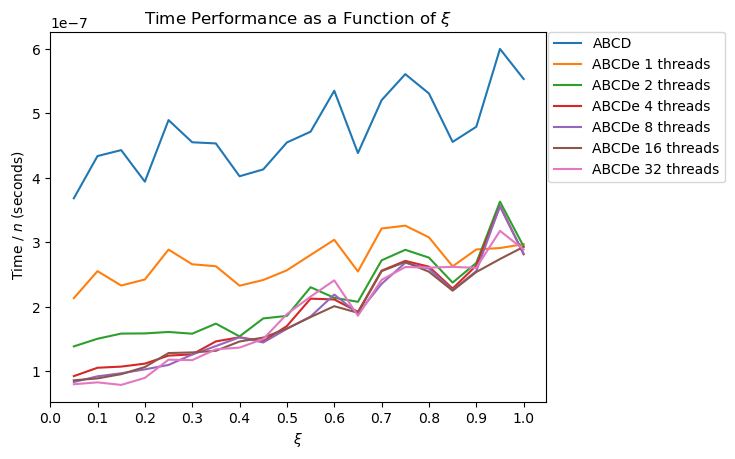

PyObject Text(0.5, 1.0, 'Time Performance as a Function of $ξ$')

In [31]:
group = groupby(groupby(fdata, [:algo, :n, :β, :γ, :min_deg])[(:ABCD, n, β, γ, min_deg)], :ξ);
x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time]./d[!,:n_edges])) for d in group]...))
plot( x,y, label = "ABCD")

for thread in threads
    group = groupby(groupby(fdata, [:algo, :n, :β, :γ, :min_deg, :threads])[(:ABCDe, n, β, γ, min_deg, thread)], :ξ);
    x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time]./d[!,:n_edges])) for d in group]...))
    plot( x,y, label = "ABCDe $thread threads")
end
legend(loc="upper right", bbox_to_anchor=(1.375, 1.02))
xticks(range(0.0, 1.0, step = 0.1))
xlabel(L"ξ")
ylabel(L" Time / $n$ (seconds)")
title(L"Time Performance as a Function of $ξ$")

#saving to a file:
#savefig("time_per_edge_xi_without_LFR.eps")

## ABCD and ABCDe is_local plots

Comparision between local and global versions of algorithm:

### Execution time per edge as function of $n$ (ABCD):

In [32]:
#Parameters

ξ = 0.2
β = 1.5
γ = 2.5
min_deg = 5
is_local = [0.0,1.0];

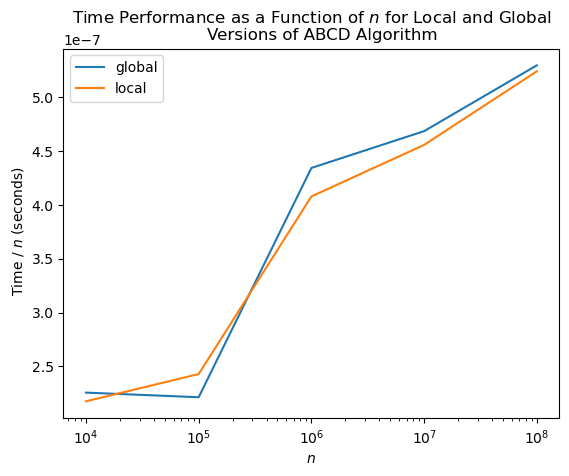

PyObject Text(0.5, 1.0, 'Time Performance as a Function of $n$ for Local and Global\n    Versions of ABCD Algorithm')

In [33]:
for islocal in is_local
    group = groupby(groupby(fdata, [:algo, :ξ, :β, :γ, :is_local, :min_deg])[(:ABCD, ξ, β, γ, islocal, min_deg)], :n);
    y = [mean(d[!,:time]./d[!,:n_edges]) for d in group]
    plot(unique(fdata[!,:n]), y,  label = Bool(islocal) ? "local" : "global")
end

legend(loc="upper left")
xscale("log")
xlabel(L"n")
ylabel(L" Time / $n$ (seconds)")
title(L"Time Performance as a Function of $n$ for Local and Global
    Versions of ABCD Algorithm")

#saving to a file:
#savefig("fig11.eps")

### Execution time per edge as function of $\xi$ (ABCD):

In [34]:
#Parameters

n = 10^7
β = 1.5
γ = 2.5
min_deg = 5
is_local = [0.0,1.0];

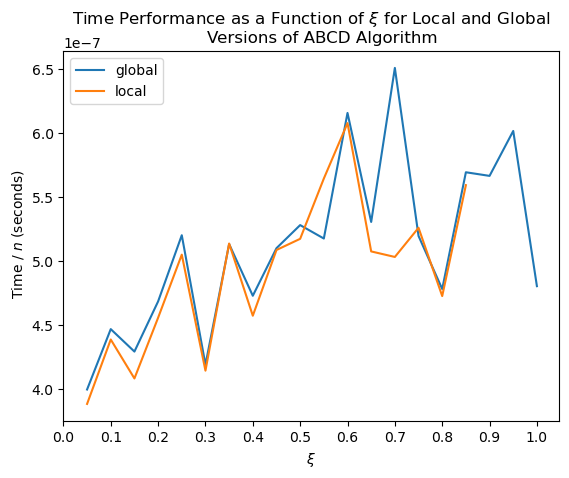

PyObject Text(0.5, 1.0, 'Time Performance as a Function of $ξ$ for Local and Global\n    Versions of ABCD Algorithm')

In [35]:
for islocal in is_local
    group = groupby(groupby(fdata, [:algo, :n, :β, :γ, :min_deg, :is_local])[(:ABCD, n, β, γ, min_deg, islocal)], :ξ);
    x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time]./d[!,:n_edges])) for d in group]...))
    plot( x,y, label = Bool(islocal) ? "local" : "global")
end

legend(loc="upper left")
xticks(range(0.0, 1.0, step = 0.1))
xlabel(L"ξ")
ylabel(L" Time / $n$ (seconds)")
title(L"Time Performance as a Function of $ξ$ for Local and Global
    Versions of ABCD Algorithm")

#saving to a file:
#savefig("fig12.eps")

### Execution time per edge as function of $n$ (ABCDe):

In [36]:
#Parameters:

ξ = 0.2
β = 1.5
γ = 2.5
min_deg = 5
thread = 4
is_local = [0.0,1.0];

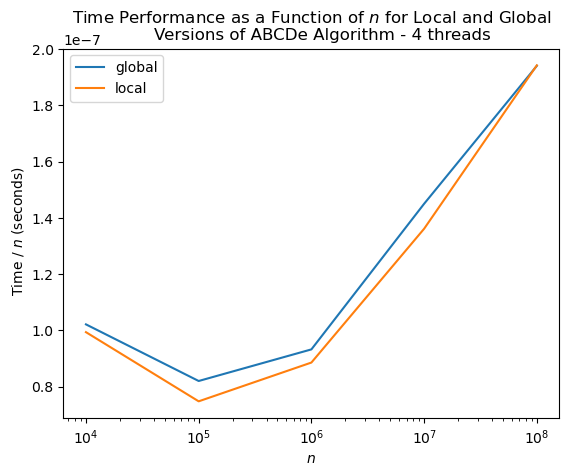

PyObject Text(0.5, 1.0, 'Time Performance as a Function of $n$ for Local and Global\n    Versions of ABCDe Algorithm - 4 threads')

In [37]:
for islocal in is_local
    group = groupby(groupby(fdata, [:algo, :ξ, :β, :γ, :is_local, :min_deg, :threads])[(:ABCDe, ξ, β, γ, islocal, min_deg, thread)], :n);
    y = [mean(d[!,:time]./d[!,:n_edges]) for d in group]
    plot(unique(fdata[!,:n]), y,  label = Bool(islocal) ? "local" : "global")
end

legend(loc="upper left")
xscale("log")
xlabel(L"n")
ylabel(L" Time / $n$ (seconds)")
title(L"Time Performance as a Function of $n$ for Local and Global
    Versions of ABCDe Algorithm - %$thread threads")

#saving to a file:
#savefig("fig13.eps")

### Execution time per edge as function of $\xi$ (ABCDe):

In [38]:
#Parameters

n = 10^6
β = 1.5
γ = 2.5
min_deg = 5
is_local = [0.0,1.0];

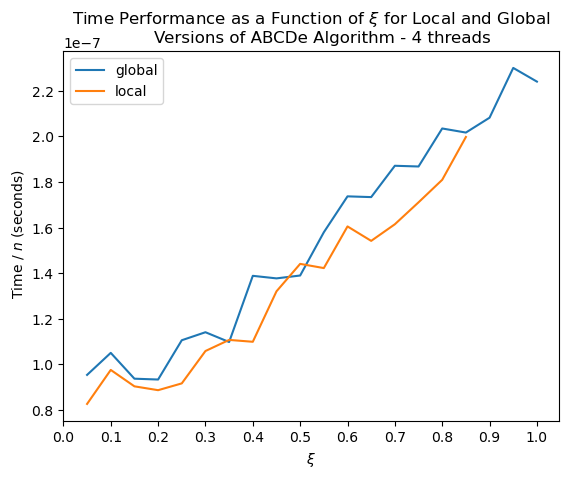

PyObject Text(0.5, 1.0, 'Time Performance as a Function of $ξ$ for Local and Global\n    Versions of ABCDe Algorithm - 4 threads')

In [39]:
for islocal in is_local
    group = groupby(groupby(fdata, [:algo, :n, :β, :γ, :is_local, :min_deg, :threads])[(:ABCDe, n, β, γ, islocal, min_deg, thread)], :ξ)
    x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time]./d[!,:n_edges])) for d in group]...))
    plot( x,y, label = Bool(islocal) ? "local" : "global")
end

legend(loc="upper left")
xticks(range(0.0, 1.0, step = 0.1))
xlabel(L"ξ")
ylabel(L" Time / $n$ (seconds)")
title(L"Time Performance as a Function of $ξ$ for Local and Global
    Versions of ABCDe Algorithm - %$thread threads")


#saving to a file:
#savefig("fig14.eps")